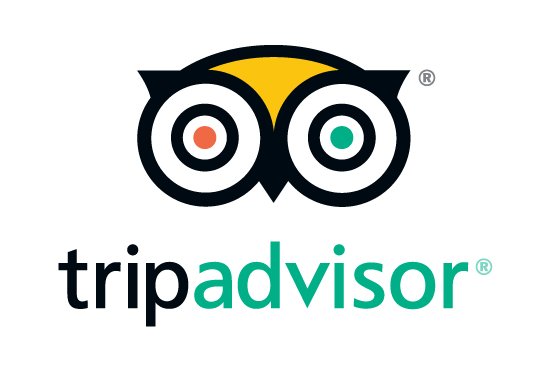

# Общая информация

    Задача проекта - построение модели, которая предсказывает рейтинг ресторана. По ней TripAdvisor сможет определить, имела ли место накрутка рейтинга рестораном.
    
    Для начала проведем разведывательный анализ предоставленных нам данных и загрузим данные в модель.

# Первичная обработка данных

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

df = pd.read_csv('main_task.csv')

# отформатируем названия столбцов
df.columns = df.columns.str.replace(' ', '_')
df = df.rename(columns=str.lower)
df['city'] = df['city'].str.upper()
'''функция для подсчета значений в виде таблицы'''


def count_val(column):
    return pd.DataFrame(df[column].value_counts(dropna=True))


'''функция для подсчета пропущенных значений и их процента от общего числа значений'''


def missing_table(df):
    mis_val = df.isnull().sum()
    percent = 100 * df.isnull().sum() / len(df)
    mis_table = pd.DataFrame({
        'Missing Values': mis_val,
        '% of Total Values': percent
    })
    return mis_table


def missing_val(column):
    # считаем все пропущенные значения
    sum_null = df[column].isnull().sum()
    # считаем процент от общего количества
    percent = 100 * df[column].isnull().sum() / len(df[column])
    return pd.DataFrame(
        {
            'Пропущенные значения': sum_null,
            '% от Общего Числа': percent
        },
        index=['столбец'])


'''функция, выводящая средние показатели: mean, median, mode'''


def mid_val(column):
    median = df[column].median()
    mode = df[column].mode()
    mean = df[column].mean()
    return display(
        pd.DataFrame({
            'Медиана': median,
            'Среднее': mean,
            'Мода': mode
        }))


'''функция для вывода краткой описательной статистики'''


def desc_stat(column):
    minimum = df[column].min()
    maximum = df[column].max()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    print(
        'Минимальное значение: {}'.format(minimum),
        '\nМаксимальное значение: {}'.format(maximum),
        '\n25-й перцентиль: {}'.format(perc25),
        '\n75-й перцентиль: {}'.format(perc75), '\nIQR: {}'.format(IQR),
        '\nГраницы выбросов: [{f}, {l}]'.format(f=perc25 - 1.5 * IQR,
                                                l=perc75 + 1.5 * IQR))


'''функция, выводящая график плотности распределения переменных (boxplot)'''


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column,
                y='rating',
                df=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:10])],
                palette="Blues",
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


'''Функция, оценивающая статистическую разницу номинативных признаков, с помощью теста Стьюдента'''


def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'].dropna(),
                     df.loc[df.loc[:, column] == comb[1], 'score'].dropna(), equal_var=False).pvalue \
                <= 0.05/len(combinations_all):
            print('Найдены статистически значимые различия для колонки',
                  column)
            break


'''Функция для подсчета разницы в датах между отзывами'''


def date_difference(row):
    if row['review_date'] != []:
        return pd.to_datetime(row['review_date']).max() - pd.to_datetime(
            row['review_date']).min()


'''Функция, определяющая насколько последний предоставленный нам отзыв свеж - разница с сегодняшним днем'''


def days_to_now(row):
    if row['review_date'] != []:
        return pd.to_datetime("now") - pd.to_datetime(row['review_date']).max()


# словарь принадлежности городов странам
countries = {
    'AUSTRIA': 'VIENNA',
    'BELGIUM': 'BRUSSELS',
    'CZECH REPUBLIC': 'PRAGUE',
    'DENMARK': 'COPENHAGEN',
    'FINLAND': 'HELSINKI',
    'FRANCE': ['PARIS', 'LYON'],
    'GERMANY': ['BERLIN', 'HAMBURG', 'MUNICH'],
    'GREECE': 'ATHENS',
    'HOLLAND': 'AMSTERDAM',
    'IRELAND': 'DUBLIN',
    'ITALY': ['MILAN', 'ROME'],
    'LUXEMBOURG': 'LUXEMBOURG',
    'NORWAY': 'OSLO',
    'POLAND': ['WARSAW', 'KRAKOW'],
    'PORTUGAL': ['LISBON', 'OPORTO'],
    'ROMANIA': 'BUDAPEST',
    'SCOTLAND': 'EDINBURGH',
    'SLOVAKIA': 'BRATISLAVA',
    'SLOVENIA': 'LJUBLJANA',
    'SPAIN': ['MADRID', 'BARCELONA'],
    'SWEDEN': 'STOCKHOLM',
    'SWITZERLAND': ['ZURICH', 'GENEVA'],
    'UNITED KINGDOM': 'LONDON',
}

# словарь с площадями представленных городов
city_pop = {
    'VIENNA': 414.6,
    'BRUSSELS': 32.61,
    'PRAGUE': 496,
    'COPENHAGEN': 88.25,
    'HELSINKI': 213.8,
    'PARIS': 105.4,
    'LYON': 47.87,
    'BERLIN': 891.8,
    'HAMBURG': 755.2,
    'MUNICH': 310.4,
    'ATHENS': 2929,
    'AMSTERDAM': 219.3,
    'DUBLIN': 115,
    'MILAN': 181.8,
    'ROME': 1285,
    'LUXEMBOURG': 51.46,
    'OSLO': 454,
    'WARSAW': 517.2,
    'KRAKOW': 327,
    'LISBON': 100,
    'OPORTO': 41.42,
    'BUDAPEST': 525.2,
    'EDINBURGH': 264,
    'BRATISLAVA': 367.6,
    'LJUBLJANA': 163.8,
    'MADRID': 604.3,
    'BARCELONA': 101.9,
    'STOCKHOLM': 188,
    'ZURICH': 87.88,
    'GENEVA': 15.93,
    'LONDON': 1572,
}


'''функция достают ключ-страну по городу-значению'''


def what_country(row):
    for k, v in countries.items():
        if row in v:
            return k

# словарь с площадями представленных городов
city_area = {
    'VIENNA': 414.6,
    'BRUSSELS': 32.61,
    'PRAGUE': 496,
    'COPENHAGEN': 88.25,
    'HELSINKI': 213.8,
    'PARIS': 105.4,
    'LYON': 47.87,
    'BERLIN': 891.8,
    'HAMBURG': 755.2,
    'MUNICH': 310.4,
    'ATHENS': 2929,
    'AMSTERDAM': 219.3,
    'DUBLIN': 115,
    'MILAN': 181.8,
    'ROME': 1285,
    'LUXEMBOURG': 51.46,
    'OSLO': 454,
    'WARSAW': 517.2,
    'KRAKOW': 327,
    'LISBON': 100,
    'OPORTO': 41.42,
    'BUDAPEST': 525.2,
    'EDINBURGH': 264,
    'BRATISLAVA': 367.6,
    'LJUBLJANA': 163.8,
    'MADRID': 604.3,
    'BARCELONA': 101.9,
    'STOCKHOLM': 188,
    'ZURICH': 87.88,
    'GENEVA': 15.93,
    'LONDON': 1572,
}

'''функция достают значение-площадь по ключу-городу'''


def what_area(row):
    for k, v in city_area.items():
        if row == k:
            return v
        
        
# таблица стран и их столиц
table = pd.read_html(
    'https://www.boldtuesday.com/pages/alphabetical-list-of-all-countries-and-capitals-shown-on-list-of-countries-poster'
)
country_data = table[0]
country_data = country_data.fillna('none')
country_data = country_data.replace('UNITED KINGDOM* (UK)', 'UNITED KINGDOM')

In [2]:
df.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,PARIS,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,STOCKHOLM,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,LONDON,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,BERLIN,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,MUNICH,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4]:
missing_table(df)

,Missing Values,% of Total Values
restaurant_id,0,0.0000
city,0,0.0000
cuisine_style,9283,23.2075
ranking,0,0.0000
rating,0,0.0000
price_range,13886,34.7150
number_of_reviews,2543,6.3575
reviews,0,0.0000
url_ta,0,0.0000
id_ta,0,0.0000


**Краткие наблюдения**  
Мы видим, что из 10 столбцов у нас только три - с числовыми значениями, включая столбец с целевой переменной.  
Три столбца имеют пропущенные значения, ощутимое количество пропущенных значений в двух из них.
Названия столбцов отлично передают содержание, рассмотрим каждый подробнее.

Разделим значения столбцов по **типу переменных**:

- количественные: number_of_reviews
- номинативные: city, cuisine_style, reviews, url_ta, id_ta
- ранговые: rating, price_range, ranking, restaurant_id

# Анализ данных

## Количественные переменные

### number_of_reviews

In [5]:
missing_val('number_of_reviews')

,Пропущенные значения,% от Общего Числа
столбец,2543,6.3575


Text(0.5, 1.0, 'Распределение количества отзывов')

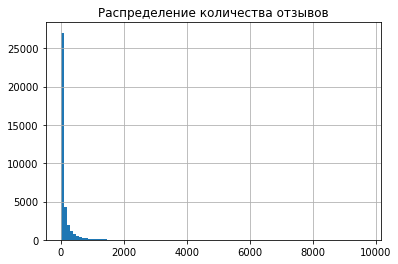

In [6]:
df['number_of_reviews'].hist(bins = 100)
plt.title('Распределение количества отзывов')

In [7]:
mid_val('number_of_reviews')

,Медиана,Среднее,Мода
0,33.0,124.82548,2.0


Значение среднего и гистрограмма нам явно указывают на выбросы, проверим их

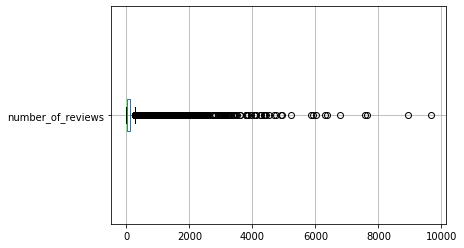

In [8]:
df.boxplot(column=['number_of_reviews'], vert=False)

In [9]:
desc_stat('number_of_reviews')

Минимальное значение: 2.0 
Максимальное значение: 9660.0 
25-й перцентиль: 9.0 
75-й перцентиль: 115.0 
IQR: 106.0 
Границы выбросов: [-150.0, 274.0]


Очень не хотелось бы удалять выбросы, которые касаются количества отзывов, но проверим, как изенится распределение и описательная статистика

In [10]:
df.loc[df['number_of_reviews'] > 300, 'number_of_reviews'] = np.nan

Text(0.5, 1.0, 'Распределение количества отзывов')

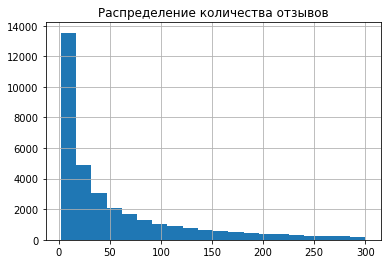

In [11]:
df['number_of_reviews'].hist(bins = 20)
plt.title('Распределение количества отзывов')

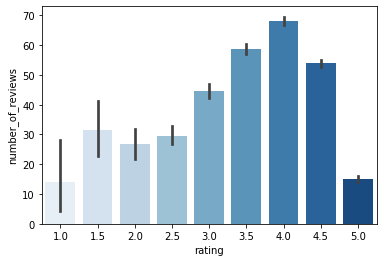

In [12]:
sns.barplot(x = 'rating', y = 'number_of_reviews', data = df, palette="Blues")

In [13]:
missing_val('number_of_reviews')

,Пропущенные значения,% от Общего Числа
столбец,6511,16.2775


Мы увеличили процент пропущенных значений, но теперь перед нами логнормальное распределение, которое будет полезнее при построении модели.  
Так же можем отметить зависимость: чем больше количество отзывов, тем выше рейтинг.  
Наивысший ранг, конечно, интересно выделяется. Это вполне могут быть маленькие заведения с очень лояльной аудиторией. Проверим это позже

## Номинативные переменные

### city

In [14]:
count_val('city')

,city
LONDON,5757
PARIS,4897
MADRID,3108
BARCELONA,2734
BERLIN,2155
MILAN,2133
ROME,2078
PRAGUE,1443
LISBON,1300
VIENNA,1166


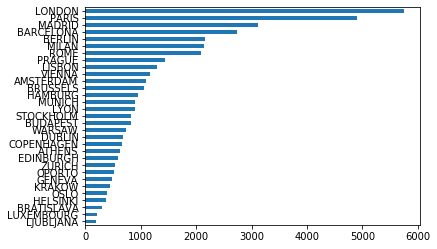

In [15]:
df['city'].value_counts(ascending=True).plot(kind='barh')

Пока можно отметить, что Лондон и Париж лидируют по количеству ресторанов

### cuisine_style

In [16]:
count_val('cuisine_style')

,cuisine_style
['Italian'],1032
['French'],805
['Spanish'],695
"['French', 'European']",405
['Cafe'],403
...,...
"['Spanish', 'Mediterranean', 'Contemporary']",1
"['Cafe', 'European', 'Central European', 'Austrian', 'Gluten Free Options', 'Vegetarian Friendly']",1
"['Asian', 'Indian', 'Diner', 'Soups', 'Vegetarian Friendly', 'Vegan Options']",1
"['Austrian', 'European', 'Wine Bar', 'Fusion', 'Vegetarian Friendly']",1


In [17]:
type(df['cuisine_style'].iloc[0])

str

In [18]:
missing_val('cuisine_style')

,Пропущенные значения,% от Общего Числа
столбец,9283,23.2075


Перед нами интересный столбец: мы видим списки видов представленных в ресторане кухонь, но записаны они в виде строк.  
Пропущенные значения представляют больше одной пятой от общего количества всех представленных данных.

### reviews

Очень грязный столбец, состоит из пары-тройки отзывов и соответствующих им дат.  
При этом есть ячейки со значениями вроде "[[], []]". Проверим, сколько их

In [19]:
df[df['reviews'] == '[[], []]']['reviews'].count()

6471

Заполнить их данными с сайта не выйдет, так как на сайте уже обновленные данные.  
Я решила работать касательно отзывов с тем, что есть. Такие пустые вложенные списки пока отметим как пропущенные значения

In [20]:
df.loc[df['reviews'] == '[[], []]', 'reviews'] = np.nan

### url_ta и id_ta

При первом взгляде можно заметить, что столбец id_ta - содержит определенную часть столбца url_ta.  
Мы видели, что значения столбца restaurant_id не уникальны, здесь же можем смело утверждать об обратном.  
Крайне маловероятно, что два разных ресторана делят одну веб-страницу. По этим мтолбцам можем определить и сбросить дубликаты

In [21]:
df.drop_duplicates(subset = ['url_ta'], inplace = True)

## Ранговые переменные

### restaurant_id

In [22]:
count_val('restaurant_id')

,restaurant_id
id_227,18
id_871,18
id_436,18
id_633,18
id_534,17
...,...
id_11494,1
id_4507,1
id_14576,1
id_11015,1


Пока мы видим, что идентификационные номера ресторанов не уникальны. Зависимости проверим позже

### rating

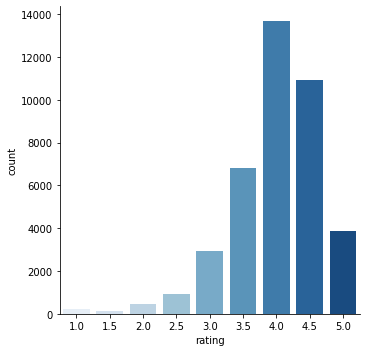

In [23]:
sns.catplot(x="rating", kind="count", palette="Blues", data=df)

Мы видим, что в представленном датасете превалирует количество ресторанов с хорошим рейтингом - 4.0

### ranking

In [24]:
count_val('ranking')

,ranking
1080.0,19
437.0,18
345.0,18
431.0,18
491.0,18
...,...
11290.0,1
7283.0,1
13570.0,1
13148.0,1


In [25]:
df[df['ranking']<100].ranking.count()

1053

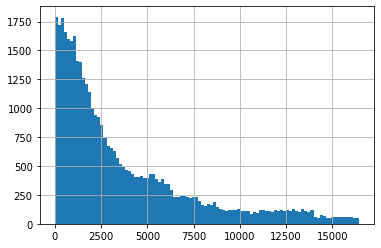

In [26]:
df['ranking'].hist(bins=100)

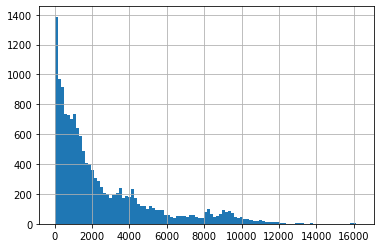

In [27]:
df['ranking'][df['rating'] > 4].hist(bins=100)

Ресторанов, входящих в первую сотню, всего 1053  
Владельцы TripAdvisor нам сообщили, что катеогрия ranking зависит во многом от отзывов: их количества, качества, свежести последних отзывов.  
Категория же rating зависит по большей части от самих оценок пользвателями

### price_range

In [28]:
missing_val('price_range')

,Пропущенные значения,% от Общего Числа
столбец,13879,34.714857


In [29]:
df['price_range'].value_counts()

$$ - $$$    18402
$            6276
$$$$         1423
Name: price_range, dtype: int64

Больше трети данных по ценовому диапазону пропущенно, будем это исправлять.  
По имеющимся данным, больше всего ресторанов в среднем ценовом диапазоне

# Подготовка данных и Featuring Engineering

### restaurant_id

При взгляде на столбец ranking можно увидеть, что числа в обоих столбцах очень близки другк другу.  
Можно проверить теорию, преобразуем значения столбца restaurant_id в числа и посмотрим на корреляцию

In [30]:
df['restaurant_id'] = df['restaurant_id'].str.split('_').apply(lambda x: int(x[1]))

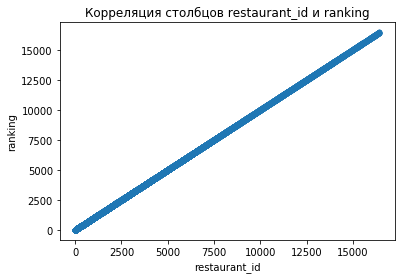

In [31]:
df.plot(x='restaurant_id',
              y='ranking',
              kind='scatter',
              title='Корреляция столбцов restaurant_id и ranking')

Видим почти полную прямую корреляцию, информативности этот столбец не даст  
При построении модели можно будет его смело игнорировать

### reviews

Посмотрим,что можно будет из него достать

In [32]:
df['reviews'].iloc[0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

Мы видим, что тут указаны отзывы постетителей и соответствующие им даты.  
Порассуждаем, как может быть устроена оценка ресторанов. Разумеется, оценка посетителями. И было бы отлично определить тональность представленных отзывов. Но так как они скорее всего были подобраны рандомно, благоразумнее было бы определить среднюю тональность по всем отзывам на сайте, что в данный момент выходит за зону моих компетенций  
Мы можем так же определить насколько свеж последний отзыв из представленных нам. Популярный ресторан - ресторан, в который ходит множество людей и часть из которых оставляет отзывы. Как воронка продаж. Итак, нам нужно определить насколько давно был оставлен последний отзыв и разницу между двумя отзывами в днях, что тоже говорит о наполняемости благодарными/разочарованными постетителями

In [33]:
# отделяем даты в отдельный столбец
df['review_date'] = df['reviews'].str.findall('\d\d/\d\d/\d{4}')

# выделяем дни из столбца с датами
df['review_days'] = df['review_date'].apply(lambda x: x if isinstance(x, float) else len(x))

In [34]:
# определяем столбец с разницей в двух последних датах
df['day_diff'] = df[df['review_days'] >= 2].apply(date_difference, axis = 1).dt.days

# определяем столбец с количеством дней с последнего отзыва до сегодняшнего дня
df['days_to_now'] = df[df['review_days']<=4].apply(days_to_now, axis = 1).dt.days

In [35]:
df['day_diff'].max()

3207.0

В нашем датасете есть и такой ресторан, в котором между двумя последними датами разница аж в 3207 дней

### city

In [36]:
df['city'].nunique()

31

Можно посмотреть как будут влиять новые признаки, созданные на основе этого столбца.  
Мы видим, что города, в основном из Европы и Великобритании. К сожалению страницу, на которой указаны разные города Европы и (подчеркнуто) Англии, я создала словарь, в котором ключами будут страны, а значениями соответствующие города

In [37]:
df['country'] = df['city'].apply(what_country)

Можно еще определить является ли город столицей или нет.  
В этом плане парсинг становится задачей попроще

In [38]:
table = pd.read_html('https://www.boldtuesday.com/pages/alphabetical-list-of-all-countries-and-capitals-shown-on-list-of-countries-poster')
capital_data = table[0]
capital_data.fillna('none')

,0,1
0,COUNTRY,CAPITAL
1,A,none
2,AFGHANISTAN,KABUL
3,ALBANIA,TIRANA
4,ALGERIA,ALGIERS
...,...,...
216,Y,none
217,YEMEN,SANA'A
218,Z,none
219,ZAMBIA,LUSAKA


In [39]:
capitals = []
for city in capital_data[1]:
    capitals.append(city)

In [40]:
df['capital'] = df['city'].apply(lambda x: 1 if x in capitals else 0)

In [41]:
df['city_pop'] = df['city'].apply(what_area)

### cuisine_style

In [42]:
# для начала преобразуем значения
df['cuisine_style'] = df['cuisine_style'].str.replace('[', '')
df['cuisine_style'] = df['cuisine_style'].str.replace(']', '')
df['cuisine_style'] = df['cuisine_style'].str.replace("'", "")
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [43]:
# заполним пропущенные значения самым частым значением по городам

df2 = df.explode('cuisine_style') # разделяем каждый вид кухни
f = lambda x: x.mode().iloc[0]
df2['cuisine_style'] = df2['cuisine_style'].fillna(df2.groupby(['country', 'city'])['cuisine_style'].transform(f)) # заполняем модой NaN-значения
df2['grouped'] = df2.groupby(df2.index).cuisine_style.agg(list) # собираем списки обратно
df2.drop_duplicates(subset = 'id_ta', inplace = True) # сжимаем датасет, чтобы сравнять длину с data
df['cuisine_style'] = df2['grouped']

In [44]:
# определим новый столбец с количеством кухонь
df['cuisine_amount'] = df['cuisine_style'].apply(lambda x: len(x) if isinstance(x, str) else 1)

### price_range

In [45]:
df.groupby(['country', 'city'])['price_range'].agg(pd.Series.mode)

country         city      
AUSTRIA         VIENNA        $$ - $$$
BELGIUM         BRUSSELS      $$ - $$$
CZECH REPUBLIC  PRAGUE        $$ - $$$
DENMARK         COPENHAGEN    $$ - $$$
FINLAND         HELSINKI      $$ - $$$
FRANCE          LYON          $$ - $$$
                PARIS         $$ - $$$
GERMANY         BERLIN        $$ - $$$
                HAMBURG       $$ - $$$
                MUNICH        $$ - $$$
GREECE          ATHENS        $$ - $$$
HOLLAND         AMSTERDAM     $$ - $$$
IRELAND         DUBLIN        $$ - $$$
ITALY           MILAN         $$ - $$$
                ROME          $$ - $$$
LUXEMBOURG      LUXEMBOURG    $$ - $$$
NORWAY          OSLO          $$ - $$$
POLAND          KRAKOW        $$ - $$$
                WARSAW        $$ - $$$
PORTUGAL        LISBON        $$ - $$$
                OPORTO        $$ - $$$
ROMANIA         BUDAPEST      $$ - $$$
SCOTLAND        EDINBURGH     $$ - $$$
SLOVAKIA        BRATISLAVA    $$ - $$$
SLOVENIA        LJUBLJANA     $$ - $$

In [46]:
df['price_range'] = df['price_range'].apply(lambda x: '$$ - $$$' if isinstance(x, float) else x)

In [47]:
df['price_range'].replace('$$$$', 3, inplace=True)
df['price_range'].replace('$', 1, inplace=True)
df['price_range'].replace('$$ - $$$', 2, inplace=True)

In [48]:
df

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,review_date,review_days,day_diff,days_to_now,country,capital,city_pop,cuisine_amount
0,5569,PARIS,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",2.0,41.0,1027.0,FRANCE,1,105.4,1
1,1535,STOCKHOLM,[European],1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",2.0,382.0,1205.0,SWEDEN,1,188.0,1
2,352,LONDON,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3,NaN,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"[01/08/2018, 01/06/2018]",2.0,2.0,1019.0,UNITED KINGDOM,1,1572.0,1
3,3456,BERLIN,[Vegetarian Friendly],3458.0,5.0,2,3.0,NaN,/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,NaN,NaN,NaN,NaN,GERMANY,1,891.8,1
4,615,MUNICH,"[German, Central European, Vegetarian Friendly]",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"[11/18/2017, 02/19/2017]",2.0,272.0,1070.0,GERMANY,0,310.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,499,MILAN,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,"[12/16/2017, 11/12/2017]",2.0,34.0,1042.0,ITALY,0,181.8,1
39996,6340,PARIS,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,2,NaN,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,"[12/21/2017, 12/12/2017]",2.0,9.0,1037.0,FRANCE,1,105.4,1
39997,1649,STOCKHOLM,"[Japanese, Sushi]",1652.0,4.5,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,"[11/03/2016, 04/12/2008]",2.0,3127.0,1450.0,SWEDEN,1,188.0,1
39998,640,WARSAW,"[Polish, European, Eastern European, Central E...",641.0,4.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,"[07/11/2017, 06/18/2017]",2.0,23.0,1200.0,POLAND,1,517.2,1


In [49]:
df['number_of_reviews'].fillna(0, inplace=True)
df['day_diff'].fillna(0, inplace=True)
df['days_to_now'].fillna(0, inplace=True)

In [50]:
dummies = pd.get_dummies(df.city.apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, dummies], axis=1)

In [51]:
dummies = pd.get_dummies(df.cuisine_style.apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, dummies], axis=1)

In [52]:
#df = data = pd.get_dummies(df, columns=[ 'country',], dummy_na=True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели¶

In [54]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['rating','reviews', 'url_ta', 'city','id_ta', 'cuisine_style','review_date', 'review_days', 'country', 'day_diff', 'days_to_now'], axis = 1)
y = df['rating']

In [55]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [56]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [57]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [58]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [59]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21525762881440721
